# Data Processing


In [1]:
import json
import urllib.request
import pandas as pd
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os

if os.path.exists('boston_311_data.pkl'):
    with open('boston_311_data.pkl', 'rb') as f:
        df_filtered = pickle.load(f)
    print("Data loaded from pickle file.")
else:
    
    query_url = 'https://data.boston.gov/api/3/action/datastore_search'

    def fetch_311_data(resource_id, limit=1000, offset=0):
        url = f'{query_url}?resource_id={resource_id}&limit={limit}&offset={offset}'
        fileobj = urllib.request.urlopen(url)
        response_dict = json.loads(fileobj.read())
        return response_dict['result']['records']

    # Accesses the resource ids for each year's data in the API request
    resource_ids_file_path = 'https://raw.githubusercontent.com/alexnoorr/CS506_FinalProject/refs/heads/DataCollection-3/Data%20Collection/resource_ids.csv'
    resource_ids_df = pd.read_csv(resource_ids_file_path)

    all_data = []

    # THIS SHOULD RUN FOR A FEW MINUTES IT'S NORMAL
    for _, row in resource_ids_df.iterrows():
        year = row['Year']
        resource_id = row['Resource ID']

        print(f"Fetching data for {year} with resource ID: {resource_id}")

        offset = 0
        batch_size = 10000

        while True:
            batch_data = fetch_311_data(resource_id, limit=batch_size, offset=offset)
            if not batch_data:
                break
            all_data.extend(batch_data)
            offset += batch_size
    df = pd.DataFrame(all_data)
    df['open_dt'] = pd.to_datetime(df['open_dt'], errors='coerce')
    df['year'] = df['open_dt'].dt.year
    print(f'This should be 3,031,846: {len(df)}')
    df_filtered = df[df['year'] != 2010]
    print(len(df_filtered)) #Smaller than 3,031,646
    
    with open('boston_311_data.pkl', 'wb') as f:
        pickle.dump(df_filtered, f)
    print("Data processed and saved to pickle file.")

subset_df = df_filtered.sample(frac=0.1,random_state=42)
print(f"Subset size: {len(subset_df)} rows")



Data loaded from pickle file.
Subset size: 304319 rows


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')

In [3]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf

###################################
# Step 1: Identify Target and Features
###################################

# this prints the distribution of departmentrs
print(subset_df['department'].value_counts())

###################################
# Step 2: Handling Class Imbalances
###################################
# certain departments are represented a lot less in the data, so we need to oversample them ensuring every class is represented
# we use the department with most numbre of rows to set the number of samples for every other department

department_counts = subset_df['department'].value_counts()
max_count = department_counts.max()

n_samples_dict = {dept: max(max_count, 400) for dept in department_counts.index}

def oversample_data(subset_df, department_col, n_samples_dict):
    oversampled_frames = []
    for dept, n_samples in n_samples_dict.items():
        dept_df = subset_df[subset_df[department_col] == dept]
        if len(dept_df) < n_samples:
            # if not enough samples, oversample with replacement
            dept_df = dept_df.sample(n=n_samples, replace=True, random_state=42)
        else:
            # if already more than needed, just sample (no need for replacement)
            dept_df = dept_df.sample(n=n_samples, replace=False, random_state=42)
        oversampled_frames.append(dept_df)
    return pd.concat(oversampled_frames, axis=0)

oversampled_df = oversample_data(subset_df, 'department', n_samples_dict)

# original_descriptors = set(subset_df['type'].unique())
# oversampled_descriptors = set(oversampled_df['type'].unique())

# missing_descriptors = original_descriptors - oversampled_descriptors
# for d in missing_descriptors:
#     print("check1")
#     print('Any unrepresented data: ', d)
# missing_rows = subset_df[subset_df['type'].isin(missing_descriptors)]
# oversampled_df = pd.concat([oversampled_df, missing_rows], axis=0)

print("Oversampled class distribution:")
print(oversampled_df['department'].value_counts())

###################################
# Step 4: Tokenize Text and Encode Target
###################################
# we will split into train/test first so we can fit tokenizer/encoder on training set only.

train_val_df, test_df = train_test_split(oversampled_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

for df_ in [train_df, val_df, test_df]:
    df_['open_dt'] = pd.to_datetime(df_['open_dt'], errors='coerce')
    df_['closed_dt'] = pd.to_datetime(df_['closed_dt'], errors='coerce')
    df_.dropna(subset=['closed_dt'], inplace=True) #dropping nulls
    # resolution time in hours
    df_['resolution_time_hours'] = (df_['closed_dt'] - df_['open_dt']).dt.total_seconds() / 3600.0
    df_['resolution_time_hours'].fillna(df_['resolution_time_hours'].median(), inplace=True)

# fit tokenizer on training data only
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['type'])

X_train_text = tokenizer.texts_to_matrix(train_df['type'], mode='binary')
X_val_text = tokenizer.texts_to_matrix(val_df['type'], mode='binary')
X_test_text = tokenizer.texts_to_matrix(test_df['type'], mode='binary')

X_train_num = train_df[['resolution_time_hours']].values
X_val_num = val_df[['resolution_time_hours']].values
X_test_num = test_df[['resolution_time_hours']].values

# combine text and numeric features
X_train = np.hstack([X_train_text, X_train_num])
X_val = np.hstack([X_val_text, X_val_num])
X_test = np.hstack([X_test_text, X_test_num])

label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(train_df['department']))
y_val = to_categorical(label_encoder.transform(val_df['department']))
y_test = to_categorical(label_encoder.transform(test_df['department']))

# save tokenizer and label encoder for future use
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

###################################
# Step 5: Creating a Random Subset of Original Data for Evaluation
###################################
# Take a random subset of the original (non-oversampled) data for realistic performance measure.

r_subset_size = 5000 
random_subset = subset_df.sample(n=r_subset_size, random_state=42)

random_subset['open_dt'] = pd.to_datetime(random_subset['open_dt'], errors='coerce')
random_subset['closed_dt'] = pd.to_datetime(random_subset['closed_dt'], errors='coerce')
random_subset.dropna(subset=['closed_dt'], inplace=True)
random_subset['resolution_time_hours'] = (random_subset['closed_dt'] - random_subset['open_dt']).dt.total_seconds() / 3600.0
random_subset['resolution_time_hours'].fillna(random_subset['resolution_time_hours'].median(), inplace=True)

X_r_test_text = tokenizer.texts_to_matrix(random_subset['type'], mode='binary')
X_r_test_num = random_subset[['resolution_time_hours']].values
X_r_test = np.hstack([X_r_test_text, X_r_test_num])

y_r_test = to_categorical(label_encoder.transform(random_subset['department']))

###################################
# Step 6: Building the Keras Neural Network Model
###################################
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

###################################
# Step 7: Training the Model
###################################
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    verbose=1
)

###################################
# Step 8: Evaluate the Model
###################################
# Evaluate on oversampled test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy (Balanced Test Set): {test_acc:.4f}")

# Evaluate on random subset of original data
r_test_loss, r_test_acc = model.evaluate(X_r_test, y_r_test, verbose=2)
print(f"Test Accuracy (Random Original Subset): {r_test_acc:.4f}")


department
PWDx    164285
BTDT     63559
ISD      26781
PARK     18183
INFO     15814
GEN_      6388
PROP      4171
BWSC      3675
ANML       660
DISB       229
BPD_       227
BPS_       128
BHA_       103
ONS_        58
DND_        43
No Q        15
Name: count, dtype: int64
Oversampled class distribution:
department
PWDx    164285
BTDT    164285
ISD     164285
PARK    164285
INFO    164285
GEN_    164285
PROP    164285
BWSC    164285
ANML    164285
DISB    164285
BPD_    164285
BPS_    164285
BHA_    164285
ONS_    164285
DND_    164285
No Q    164285
Name: count, dtype: int64


C:\Users\nlnlg\AppData\Local\Temp\ipykernel_8740\2350069630.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_['resolution_time_hours'].fillna(df_['resolution_time_hours'].median(), inplace=True)
C:\Users\nlnlg\AppData\Local\Temp\ipykernel_8740\2350069630.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

Epoch 1/50
26349/26349 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.7320 - loss: 2.4972 - val_accuracy: 0.7779 - val_loss: 0.6541
Epoch 2/50
26349/26349 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - accuracy: 0.7711 - loss: 0.7077 - val_accuracy: 0.7601 - val_loss: 0.7285
Epoch 3/50
26349/26349 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - accuracy: 0.7870 - loss: 0.6560 - val_accuracy: 0.7644 - val_loss: 0.6749
Epoch 4/50
26349/26349 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.7924 - loss: 0.6256 - val_accuracy: 0.8243 - val_loss: 0.5593
Epoch 5/50
26349/26349 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.8027 - loss: 0.6023 - val_accuracy: 0.8271 - val_loss: 0.5486
Epoch 6/50
26349/26349 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.8044 - loss: 0.6018 - val_accuracy: 0.7795 - val_loss: 0.6547
Epoch 7/50
26349/26349 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - accuracy: 0.7893 - loss: 0.6389 - val_accuracy: 0.7912 - val_loss: 0.6087
Epoch 8/50
26349/26349 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 

# Visualizing Accuracy and Loss over Epochs

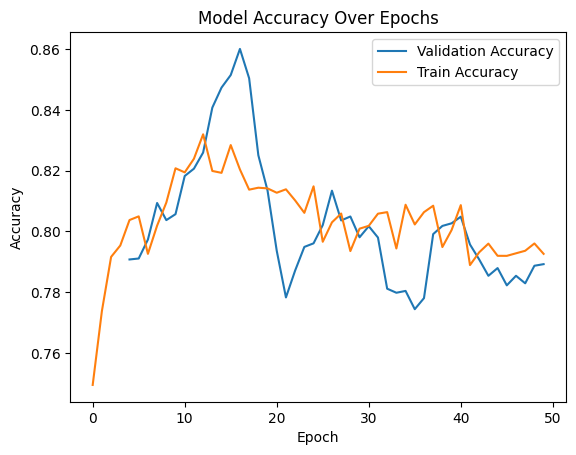

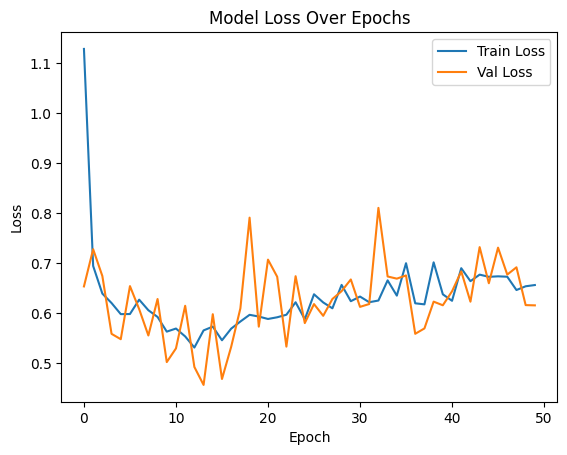

In [5]:
smooth_values = pd.Series(history.history['val_accuracy']).rolling(window=5).mean()
plt.plot(smooth_values, label = 'Validation Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()